# Main Analysis

This file does not rely on user input. So we would like to keep it interchangeable with the actual main_analysis.py file.
So please keep all the >relevant< code within one code block. (If you want to inspect certain elements or do other things that are not relevant to the main analysis, you can of course add them in new blocks).

In [1]:
import sys
import os.path as op
module_path = op.abspath(op.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import numpy as np
import mne
from hypyp.prep import AR_local

from data_analysis.functions_preprocessing import \
    (combine_raws, split_raws, combine_epochs, split_epochs,
     preprocess_single_sub, load_ica, load_autoreject)
from data_analysis.functions_behavioral import \
    (create_event_df, remove_ghost_triggers, calculate_alpha,
     join_event_dfs, remove_outliers, events_from_event_df)
from data_analysis.functions_connectivity import \
    epochs_ispc
from data_analysis.functions_graph_theory import \
    epochs_weighted_small_world_coeff



subject_dir = "/net/store/nbp/projects/hyperscanning/hyperscanning-2.0/mne_data/sourcedata/"
behav_dir = "/net/store/nbp/projects/hyperscanning/study_project/NBP_Hyperscanning/data_analysis/Behavioural_Analysis/BehaviouralData"



# Main Data Analysis ###################################
# initialize containers to analyze later
connectivity_matrices = []
small_world_coeffs = []

# Perform the data analysis
for subj_pair in ['202']:  #['202','203','204','205','206','207','208','209','211','212']:

    subs_path = subject_dir + "sub-{0}/eeg/sub-{0}_task-hyper_eeg.fif".format(subj_pair)
    behav_path = op.join(behav_dir, "{0}.csv".format(subj_pair))

    combined_raw = mne.io.read_raw_fif(subs_path, preload=True)

    # split the subjects and delete the raw file
    raws = split_raws(combined_raw)
    del combined_raw
    
    for i, _ in enumerate(raws):
        # set the EEG Montage. We use 64 chans from the standard 10-05 system.
        montage = mne.channels.make_standard_montage("standard_1005")
        raws[i].set_montage(montage)

    # combine the subjects again
    raw_combined = combine_raws(raws[0], raws[1])
    del raws  # to save memory

    # do the behavioral analysis and get the epochs
    behavioral_df = calculate_alpha(pd.read_csv(behav_path))
    event_df = create_event_df(raw_combined)
    event_df = remove_ghost_triggers(event_df)
    event_df = join_event_dfs(event_df, behavioral_df)
    
    # get the first tap by looking at the first sample in each trial
    min_idx = event_df.groupby(["trial"])["sample"].idxmin()
    early_df = event_df[event_df.index.isin(min_idx)]
    early_events = events_from_event_df(early_df)
    
    # get the late taps by looking at the last sample - 1.5 seconds
    max_idx = event_df.groupby(["trial"])["sample"].idxmax()
    late_df = event_df[event_df.index.isin(max_idx)]
    late_events = events_from_event_df(late_df)
    late_events[:,0] -= int(raw_combined.info["sfreq"] * 1.5)
    
    # get the baseline events
    base_events = mne.pick_events(mne.find_events(raw_combined, shortest_event=1),
                              include=48)

    # define the parameters for epoching
    combined_events = np.vstack([base_events, early_events, late_events])
    tmin = 0
    tmax = 1.5

    # epoch the data. Here we filter out bad segments from both participants
    epochs = mne.Epochs(raw_combined, combined_events, tmin=tmin, tmax=tmax,
                        picks=["eeg"], baseline=None, preload=True) # only use the first two epochs
    
    # we have to combine both autoreject thresholds first and remove the manually
    #rejects = [load_autoreject("sub-{0}_p-{1}".format(subj_pair, i)).get_reject_log(split_epochs(epochs)[i]).bad_epochs for i in range(2)]
    #combined_rejects = np.logical_or(rejects[0], rejects[1])
    
    rejects = np.hstack([[load_autoreject("sub-{0}_p-{1}-{2}".format(subj_pair, i, condition)).get_reject_log(split_epochs(epochs[eventcode])[i]).bad_epochs for i in range(2)] for eventcode, condition in [("48", "baseline"), (("6", "15"), "early"), (("14", "23"), "late")]])
    combined_rejects = np.logical_or(rejects[0], rejects[1])
    
    # apply the heuristic to reject all parts of a trial if 2 or more epochs out of
    # baseline, early, and late, are bad.
    #bad_trials = np.vstack([combined_rejects[:300],
    #                        combined_rejects[300:600],
    #                        combined_rejects[600:]])
    #bad_trial_sets = np.sum(bad_trials, axis=0) >= 1
    #combined_rejects = np.hstack([bad_trial_sets] * 3)
    
    epochs = epochs.drop(combined_rejects, reason="Autoreject")
    
     # split the epochs to apply ICA individually
    epochs_split = list(split_epochs(epochs))
    for i, cur_eps in enumerate(epochs_split):
        subj_id = "sub-{0}_p-{1}".format(subj_pair, i)
        
        condition_split = []
        for eventcode, condition in [("48", "baseline"), (("6", "15"), "early"), (("14", "23"), "late")]:
        
            cur_cond_eps = cur_eps[eventcode]
            
            # apply autoreject (exclude bads and interpolate)
            # TODO: The Autoreject guys apply ICA first and then autoreject local. i would do the same
            # Applying ICA first will look ugly, but for the first pair, it saves ~ 50 epochs
            ar = load_autoreject(subj_id + "-" + condition)
            cur_cond_eps = ar.transform(cur_cond_eps, return_log=False)

            # apply ICA
            ica = load_ica(subj_id)
            cur_cond_eps = ica.apply(cur_cond_eps)
            
            condition_split.append(cur_cond_eps)
            
        # concatenate the different conditions again
        cur_eps = mne.concatenate_epochs(condition_split)
        
        # rereference to avg ref
        cur_eps.set_eeg_reference(ref_channels='average')

        # apply surface laplacian
        cur_eps = mne.preprocessing.compute_current_source_density(cur_eps,
                                                                   stiffness=10,
                                                                   lambda2=1e-5)
        epochs_split[i] = cur_eps

    #combine the epochs again
    epochs = combine_epochs(epochs_split[0], epochs_split[1])
    #del epochs_split
    
    # frequencies should be 25 freqs, log spaced between 4 and 50
    freqs = np.logspace(np.log10(4), np.log10(45), 20)
    cycles = freqs / 2.
    
    raise ValueError("YOU SHALL NOT PASS!")
    print("STARTING WITH ISPC")
    
    # calculate the ISPC
    ispc_matrix, freqs, times = epochs_ispc(epochs, freqs, cycles, n_jobs=4)
    
    print("ISPC DONE")
    
    # calculate the small world coefficient
    small_worlds = epochs_weighted_small_world_coeff(ispc_matrix)
    
    # append the results to the respective lists
    connectivity_matrices.append(ispc_matrix)
    small_world_coeffs.append(small_worlds)




Bad key "text.kerning_factor" on line 4 in
/net/store/nbp/projects/hyperscanning/study_project/programming_tools/miniconda3/envs/hyperscanning/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


Opening raw data file /net/store/nbp/projects/hyperscanning/hyperscanning-2.0/mne_data/sourcedata/sub-202/eeg/sub-202_task-hyper_eeg.fif...


<ipython-input-1-1f31fd894666>:41: RuntimeWarning: This filename (/net/store/nbp/projects/hyperscanning/hyperscanning-2.0/mne_data/sourcedata/sub-202/eeg/sub-202_task-hyper_eeg.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  combined_raw = mne.io.read_raw_fif(subs_path, preload=True)


Isotrak not found
    Range : 0 ... 3725311 =      0.000 ...  3637.999 secs
Ready.
Opening raw data file /net/store/nbp/projects/hyperscanning/hyperscanning-2.0/mne_data/sourcedata/sub-202/eeg/sub-202_task-hyper_eeg-1.fif...
Isotrak not found
    Range : 3725312 ... 5675445 =   3638.000 ...  5542.427 secs
Ready.
Reading 0 ... 5675445  =      0.000 ...  5542.427 secs...
EEG channel type selected for re-referencing
Applying a custom EEG reference.
EEG channel type selected for re-referencing
Applying a custom EEG reference.
6648 events found
Event IDs: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 36 37 38 39 40 41 42 43 44 45 46 48 49]
6648 events found
Event IDs: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 36 37 38 39 40 41 42 43 44 45 46 48 49]
900 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Loading data for 90

<ipython-input-1-1f31fd894666>:83: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw_combined, combined_events, tmin=tmin, tmax=tmax,


0 bad epochs dropped
Dropped 321 epochs: 0, 2, 3, 4, 5, 7, 10, 17, 20, 23, 27, 32, 40, 42, 44, 48, 50, 52, 53, 54, 55, 58, 62, 65, 67, 68, 69, 79, 81, 83, 84, 88, 90, 93, 99, 102, 106, 107, 109, 111, 112, 120, 125, 126, 135, 138, 141, 142, 145, 146, 154, 157, 161, 162, 164, 167, 169, 174, 178, 181, 185, 187, 188, 195, 197, 199, 207, 211, 214, 218, 222, 225, 226, 228, 230, 235, 238, 239, 241, 242, 244, 245, 246, 247, 250, 251, 252, 254, 255, 256, 269, 270, 272, 273, 274, 275, 276, 277, 284, 285, 291, 292, 293, 298, 305, 309, 312, 316, 320, 324, 328, 336, 341, 342, 344, 352, 358, 361, 364, 373, 375, 378, 381, 383, 385, 390, 391, 392, 393, 394, 402, 403, 404, 405, 407, 409, 412, 432, 434, 435, 438, 440, 441, 442, 443, 444, 457, 460, 465, 467, 468, 470, 474, 478, 485, 486, 489, 491, 493, 494, 495, 497, 508, 509, 510, 511, 513, 518, 519, 522, 524, 528, 533, 537, 539, 543, 547, 548, 549, 550, 551, 552, 553, 554, 555, 557, 558, 563, 564, 568, 570, 571, 581, 582, 588, 592, 594, 595, 596, 598, 


No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Reading /net/store/nbp/projects/hyperscanning/study_project/dirk/NBP_Hyperscanning/data_analysis/bads/bad_components/sub-202_p-0-ica.fif ...
Now restoring ICA solution ...
Ready.
Transforming to ICA space (63 components)
Zeroing out 1 ICA component



No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Reading /net/store/nbp/projects/hyperscanning/study_project/dirk/NBP_Hyperscanning/data_analysis/bads/bad_components/sub-202_p-0-ica.fif ...
Now restoring ICA solution ...
Ready.
Transforming to ICA space (63 components)
Zeroing out 1 ICA component



No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Reading /net/store/nbp/projects/hyperscanning/study_project/dirk/NBP_Hyperscanning/data_analysis/bads/bad_components/sub-202_p-0-ica.fif ...
Now restoring ICA solution ...
Ready.
Transforming to ICA space (63 components)
Zeroing out 1 ICA component
579 matching events found
No baseline correction applied
Not setting metadata
0 bad epochs dropped
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Fitted sphere radius:         95.1 mm
Origin head coordinates:      0.9 6.5 47.0 mm
Origin device coordinates:    0.9 6.5 47.0 mm



No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Reading /net/store/nbp/projects/hyperscanning/study_project/dirk/NBP_Hyperscanning/data_analysis/bads/bad_components/sub-202_p-1-ica.fif ...
Now restoring ICA solution ...
Ready.
Transforming to ICA space (63 components)
Zeroing out 1 ICA component



No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Reading /net/store/nbp/projects/hyperscanning/study_project/dirk/NBP_Hyperscanning/data_analysis/bads/bad_components/sub-202_p-1-ica.fif ...
Now restoring ICA solution ...
Ready.
Transforming to ICA space (63 components)
Zeroing out 1 ICA component



No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Reading /net/store/nbp/projects/hyperscanning/study_project/dirk/NBP_Hyperscanning/data_analysis/bads/bad_components/sub-202_p-1-ica.fif ...
Now restoring ICA solution ...
Ready.
Transforming to ICA space (63 components)
Zeroing out 1 ICA component
579 matching events found
No baseline correction applied
Not setting metadata
0 bad epochs dropped
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Fitted sphere radius:         95.1 mm
Origin head coordinates:      0.9 6.5 47.0 mm
Origin device coordinates:    0.9 6.5 47.0 mm


ValueError: YOU SHALL NOT PASS!

## Investigate stuff

300 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Loading data for 300 events and 3073 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows


<ipython-input-2-282f6d308e19>:5: UserWarning: Infinite value in PSD for channel sub1_Cz.
These channels might be dead.
  a = eps.plot_psd(picks=[ch for ch in eps.ch_names if "sub1" in ch], fmin=2, fmax=50, average=True, area_mode=None)


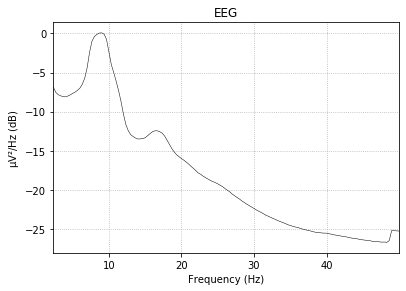

    Using multitaper spectrum estimation with 7 DPSS windows


<ipython-input-2-282f6d308e19>:6: UserWarning: Infinite value in PSD for channel sub2_Cz.
These channels might be dead.
  b = eps.plot_psd(picks=[ch for ch in eps.ch_names if "sub2" in ch], fmin=2, fmax=50, average=True, area_mode=None)


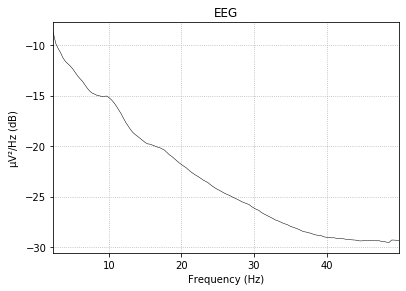

In [2]:

eps = mne.Epochs(raw_combined, early_events, tmin=tmin, tmax=3,
                 picks=["eeg"], baseline=None, preload=True)


a = eps.plot_psd(picks=[ch for ch in eps.ch_names if "sub1" in ch], fmin=2, fmax=50, average=True, area_mode=None)
b = eps.plot_psd(picks=[ch for ch in eps.ch_names if "sub2" in ch], fmin=2, fmax=50, average=True, area_mode=None)


In [51]:
raw_combined

<Raw | sub-202_task-hyper_eeg.fif, 144 x 5675446 (5542.4 s), ~6.09 GB, data loaded>

In [15]:
import pandas as pd

In [27]:
    # apply the heuristic to reject all parts of a trial if 2 or more epochs out of
    # baseline, early, and late, are bad.
    bad_trials = np.vstack([combined_rejects[:300],
                            combined_rejects[300:600],
                            combined_rejects[600:]])
    bad_trial_sets = np.sum(bad_trials, axis=0) >= 2
    combined_rejects = np.hstack([bad_trial_sets] * 3)
    
    epochs = epochs.drop(combined_rejects, reason="Autoreject")
    
     # split the epochs to apply ICA individually
    epochs_split = list(split_epochs(epochs))
    for i, cur_eps in enumerate(epochs_split):
        subj_id = "sub-{0}_p-{1}".format(subj_pair, i)

        # apply autoreject (exclude bads and interpolate)
        # TODO: The Autoreject guys apply ICA first and then autoreject local. i would do the same
        # Applying ICA first will look ugly, but for the first pair, it saves ~ 50 epochs
        #ar = load_autoreject(subj_id)
        #cur_eps = ar.transform(cur_eps, return_log=False)

        # apply ICA
        ica = load_ica(subj_id)
        epochs_split[i] = ica.apply(cur_eps)
        
    # for AR_local from hypyp, we have to work on the list again
    epochs_split, AR_dict = AR_local(epochs_split)  # would be nice to test out parameter strategy="intersection"
    
    for i, cur_eps in enumerate(epochs_split):
        
        # rereference to avg ref
        cur_eps.set_eeg_reference(ref_channels='average')

        # apply surface laplacian
        cur_eps = mne.preprocessing.compute_current_source_density(cur_eps,
                                                                   stiffness=10,
                                                                   lambda2=1e-5)
        epochs_split[i] = cur_eps

107

In [28]:

    
    
    epochs_split = list(split_epochs(epochs))
    for i, cur_eps in enumerate(epochs_split):
        subj_id = "sub-{0}_p-{1}".format(subj_pair, i)

        # apply autoreject (exclude bads and interpolate)
        # TODO: The Autoreject guys apply ICA first and then autoreject local. i would do the same
        ar = load_autoreject(subj_id)
        cur_eps = ar.transform(cur_eps, return_log=False)

        # apply ICA
        ica = load_ica(subj_id)
        cur_eps = ica.apply(cur_eps)
        
        # rereference to avg ref
        cur_eps.set_eeg_reference(ref_channels='average')

        # APPLY LAPLACIAN
        cur_eps = mne.preprocessing.compute_current_source_density(cur_eps,
                                                                   stiffness=10,
                                                                   lambda2=1e-5)

Dropped 435 epochs: 0, 1, 2, 3, 4, 5, 8, 9, 10, 12, 16, 17, 22, 23, 24, 28, 30, 31, 35, 36, 39, 40, 41, 44, 47, 48, 49, 50, 52, 53, 55, 59, 60, 61, 64, 65, 66, 67, 68, 70, 71, 78, 79, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 97, 99, 100, 102, 107, 114, 116, 120, 121, 123, 126, 132, 133, 135, 138, 140, 144, 145, 146, 147, 152, 155, 157, 158, 160, 164, 166, 167, 168, 170, 173, 174, 175, 176, 178, 179, 180, 181, 182, 184, 185, 186, 188, 190, 191, 192, 193, 195, 197, 199, 203, 206, 208, 210, 211, 212, 213, 215, 217, 218, 219, 220, 222, 223, 224, 225, 226, 227, 229, 231, 232, 235, 237, 238, 239, 240, 242, 246, 250, 251, 252, 254, 255, 256, 257, 258, 259, 260, 265, 267, 270, 273, 274, 275, 276, 277, 279, 282, 283, 284, 285, 286, 288, 290, 291, 293, 295, 297, 299, 312, 313, 316, 318, 320, 322, 324, 325, 330, 331, 336, 338, 341, 345, 347, 354, 356, 358, 360, 361, 362, 364, 373, 381, 383, 386, 389, 390, 391, 392, 393, 394, 395, 398, 403, 404, 407, 409, 413, 425, 430, 434, 435


No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Reading /net/store/nbp/projects/hyperscanning/study_project/dirk/NBP_Hyperscanning/data_analysis/bads/bad_components/sub-202_p-0-ica.fif ...
Now restoring ICA solution ...
Ready.
Transforming to ICA space (63 components)
Zeroing out 1 ICA component
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Fitted sphere radius:         95.1 mm
Origin head coordinates:      0.9 6.5 47.0 mm
Origin device coordinates:    0.9 6.5 47.0 mm



No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Reading /net/store/nbp/projects/hyperscanning/study_project/dirk/NBP_Hyperscanning/data_analysis/bads/bad_components/sub-202_p-1-ica.fif ...
Now restoring ICA solution ...
Ready.
Transforming to ICA space (63 components)
Zeroing out 2 ICA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Fitted sphere radius:         95.1 mm
Origin head coordinates:      0.9 6.5 47.0 mm
Origin device coordinates:    0.9 6.5 47.0 mm


In [3]:
    # we have to combine both autoreject thresholds first and remove the manually
    rejects = [load_autoreject("sub-{0}_p-{1}".format(subj_pair, i)).get_reject_log(split_epochs(epochs)[i]).bad_epochs for i in range(2)]
    combined_rejects = np.logical_or(rejects[0], rejects[1])
    epochs = epochs.drop(combined_rejects, reason="Autoreject")[::30]

OSError: file "/net/store/nbp/projects/hyperscanning/study_project/dirk/NBP_Hyperscanning/data_analysis/bads/bad_autoreject/sub-204_p-1-ar.hdf5" not found

In [39]:
    epochs_split = list(split_epochs(epochs))

IndexError: index 64 is out of bounds for axis 0 with size 64

In [ ]:
a = [True if i ==[] else False for i in epochs_split[0].drop_log]
b = [True if i ==[] else False for i in epochs_split[1].drop_log]

drop_mask = np.logical_and(a, b)
drop_log = [a + b for a, b in zip(epochs_split[0].drop_log, epochs_split[1].drop_log)]
np.sum(drop_mask)



#np.array(epochs_split[0].drop_log)
#[i for i in epochs_split[0].drop_log if ]
#epochs_split[i].drop_log != []
#np.logical_and(, epochs_split[0].drop_log)

In [ ]:
# get number of bad_epochs
combined_epochs = np.logical_or(ars[0].get_reject_log(epochs).bad_epochs, ars[1].get_reject_log(epochs).bad_epochs)

In [ ]:
sum(combined_epochs)

In [ ]:
subj_id